# Numero di Riproduzione

Stime di Rt.

> Max Pierini, Alessio Pamovio

Leggi [qui](https://maxpierini.it/R0.pdf) per dettagli generali

Legenda:

- $R_t$ numero di riproduzione effettivo
    - Rosso: maggiore di 1
    - Verde: minore di 1

In [1]:
import json
import requests
import datetime as dt

import pickle

from IPython.display import display, Math, Latex, Image, HTML, Markdown

import arviz as az

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy.optimize import curve_fit, brentq
from scipy import stats as sps
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd

In [2]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
italy = pd.read_csv(
    url,
    usecols=[
        'data', 'nuovi_positivi',
    ],
    parse_dates=['data'],
    index_col=['data'],
    squeeze=True).sort_index()

In [3]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
                     usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
                     parse_dates=['data'],
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()
days = states.index.get_level_values('data').unique()
regions = states.index.get_level_values('denominazione_regione').unique().sort_values()

In [4]:
_ = """print(f"FIRST ENTRY DATE: {italy.index[0]}")

print(f"LAST  ENTRY DATE: {italy.index[-1]}")

period = (
    italy.index[-1] -
    italy.index[0]
).days

print("COVERAGE: {} days".format(period))

print("CURRENT DATE IS:  {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))"""

In [5]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

def hampel_filter_dataframe(dataframe, window, sigmas):
    framedict = {'data': dataframe.index}
    for col in dataframe.columns:
        filtered, _ = hampel_filter_pandas(dataframe[col], window, sigmas)
        framedict.update({col: filtered})
    newframe = pd.DataFrame(framedict)
    newframe.set_index('data', inplace=True)
    return newframe

In [6]:
filtered_italy, italy_ouliers = hampel_filter_pandas(italy, 7, 2)

smoothed_italy = filtered_italy.rolling(14,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=5).round()

# Rt con MCMC

Vedi **Modello Predittivo** per dettagli sul metodo di calcolo di $R_t$ con Markov chain Monte Carlo (MCMC).

## Italia

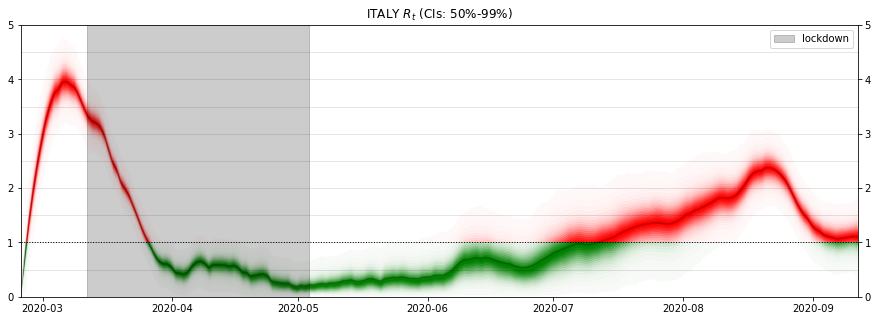

In [7]:
with open('posterior_samples_italy_R.pkl', 'rb') as f:
    jags_posteriors_italy = pickle.load(f)
    
percs = np.linspace(50, 99, 20)

daysR = days[:jags_posteriors_italy.shape[0]]

ymax = np.array([])
uppers = np.ndarray(shape=(len(percs), daysR.size))
lowers = np.ndarray(shape=(len(percs), daysR.size))

pyjags_data_italy = az.from_pyjags(
    {"R": jags_posteriors_italy}, 
    warmup_iterations=2000, save_warmup=False)
summary = az.summary(pyjags_data_italy, var_names="R", kind="stats")
for i, p in enumerate(percs[::-1]):
    upper = np.percentile(pyjags_data_italy.posterior.R, p, axis=1)
    upper = np.mean(upper, axis=0)
    lower = np.percentile(pyjags_data_italy.posterior.R, 100-p, axis=1)
    lower = np.mean(lower, axis=0)
    ymax = np.append(ymax, upper.max())
    uppers[i] = upper
    lowers[i] = lower

        
fig, ax = plt.subplots(figsize=(15, 5))

steps = .4/(len(percs)-1)
for i, (upper, lower) in enumerate(zip(uppers, lowers)):
    alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
    ax.fill_between(daysR, np.zeros(lower.size), lower, color="w", alpha=alpha)
    ax.fill_between(daysR, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

ax.fill_betweenx(
    [0,100],
    daysR[daysR>=pd.to_datetime("2020-03-11")][0],
    daysR[daysR<=pd.to_datetime("2020-05-04")][-1],
    color="k", alpha=.2, label="lockdown"
)
    
ax.plot(daysR, summary["mean"], c="k", alpha=.25)

ax.hlines(np.arange(0, 12, .5), daysR[0], daysR[-1], color="k", lw=1, alpha=.1)
ax.axhline(1, c="k", ls=":", lw=1)

ax.fill_between(daysR, 1, 12, color="red", zorder=0) #, alpha=.2)
ax.fill_between(daysR, 0, 1, color="green", zorder=0) #, alpha=.2)

ax.set_xlim(daysR[0], daysR[-1])

ax.set_title(fr"ITALY $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

ax.set_ylim(0, 5)
ax.yaxis.set_ticks_position('both')
ax.tick_params(labelright=True)
ax.legend()

fig.set_facecolor('w'); plt.show();
plt.close(fig="all")

In [8]:
Rt_italy_json = {
    'mean': summary['mean'][-1],
    'max': uppers[0,-4],
    'min': lowers[0,-4]
}
with open('Rt_italy.json', 'w') as f:
    json.dump(Rt_italy_json, f)

In [9]:
with open('posterior_samples_regions_R.pkl', 'rb') as f:
    jags_posteriors_regions = pickle.load(f)

## Abruzzo

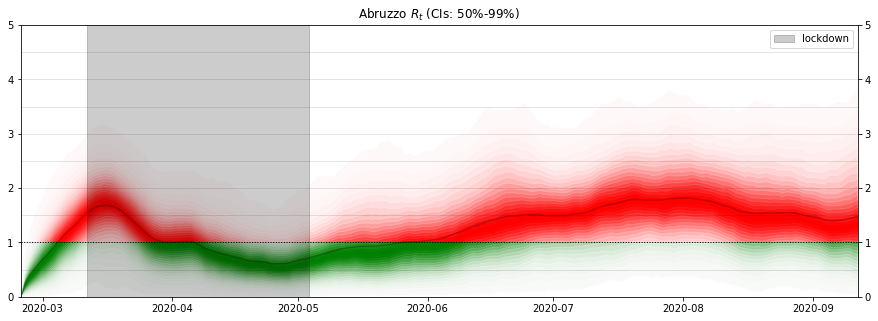

## Basilicata

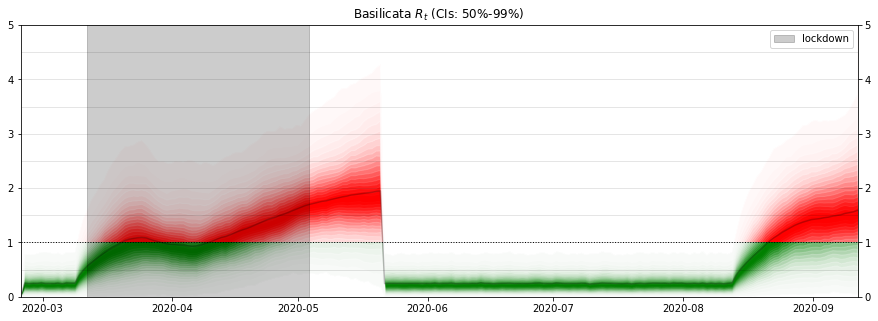

## Calabria

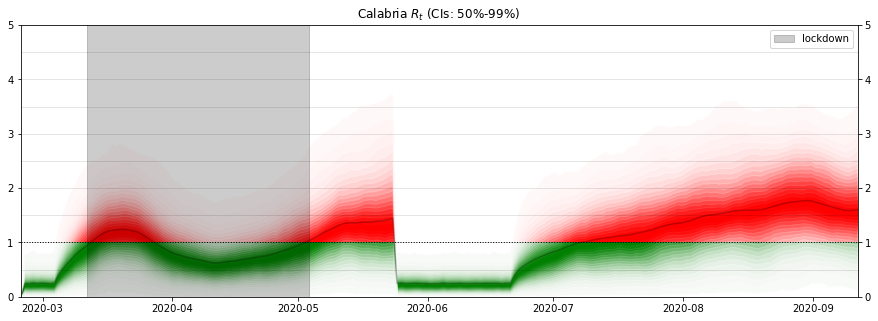

## Campania

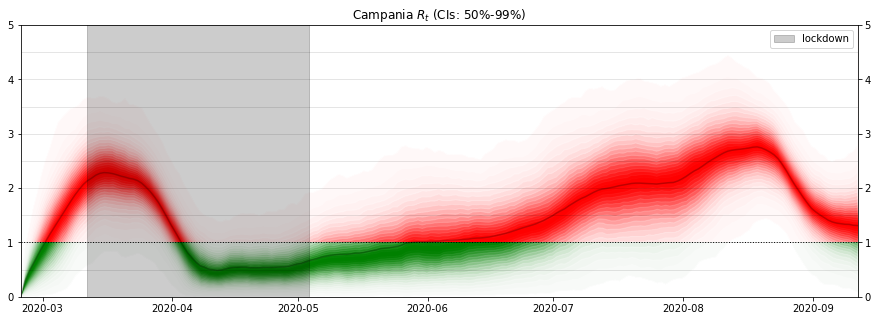

## Emilia-Romagna

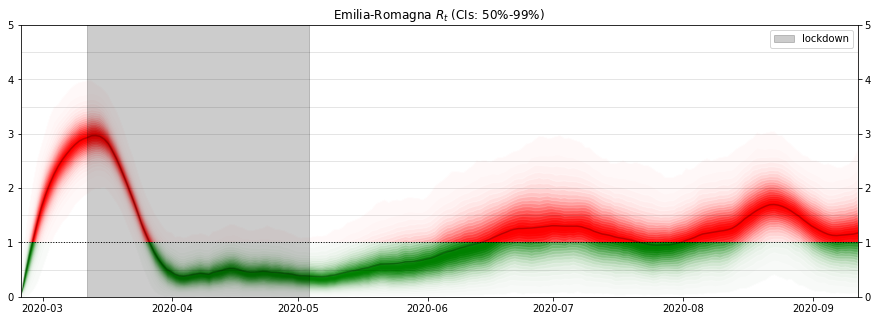

## Friuli Venezia Giulia

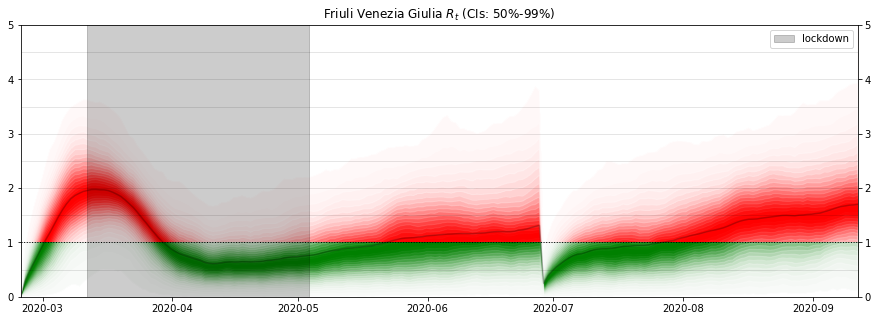

## Lazio

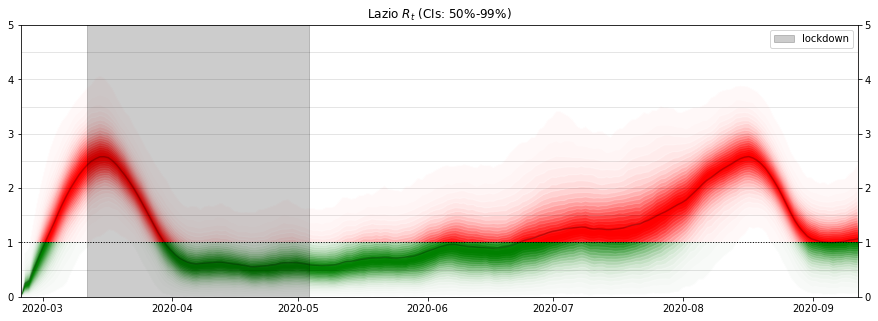

## Liguria

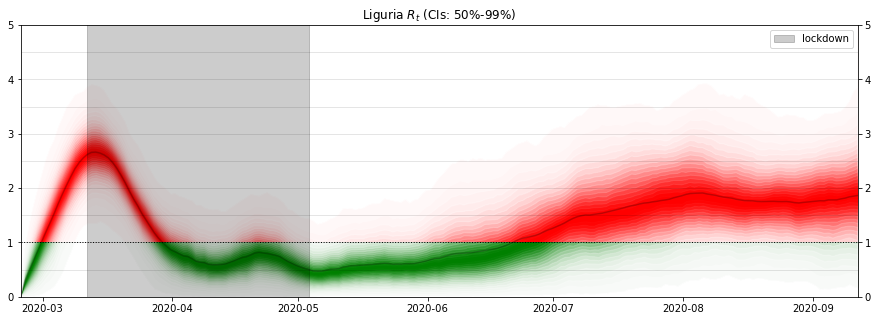

## Lombardia

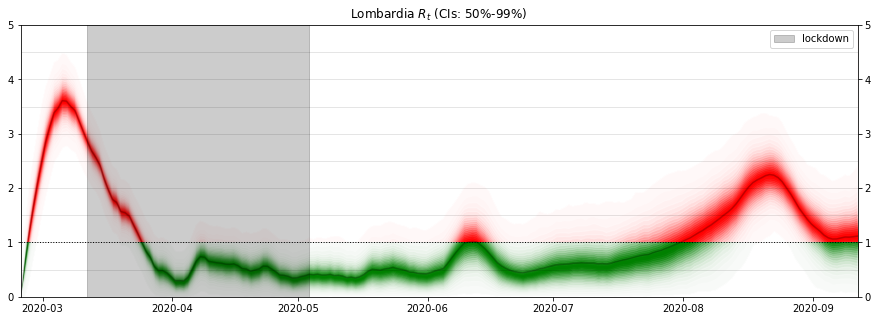

## Marche

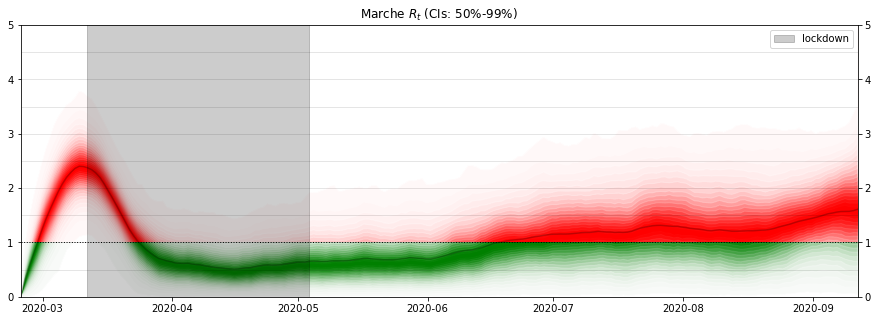

## Molise

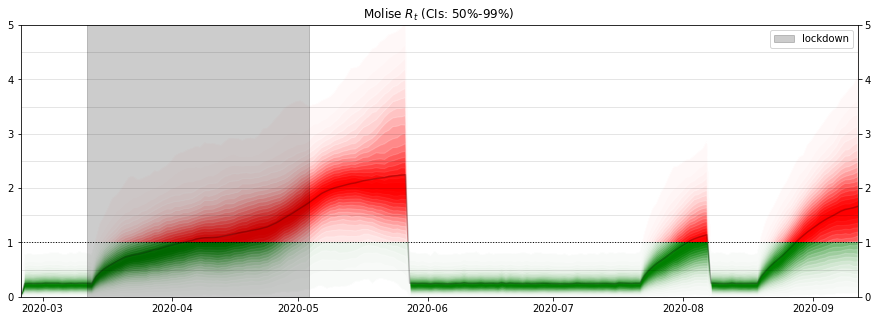

## P.A. Bolzano

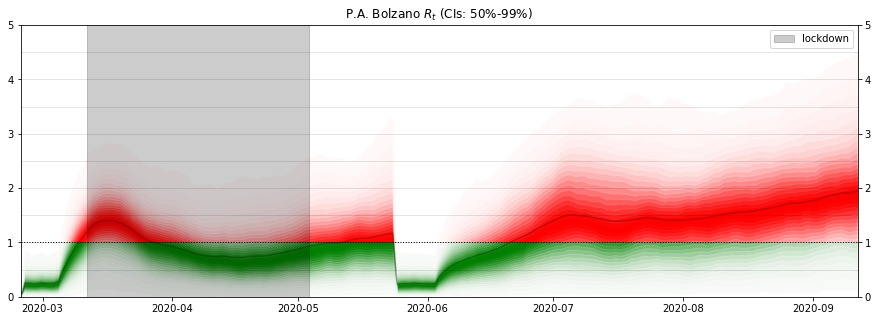

## P.A. Trento

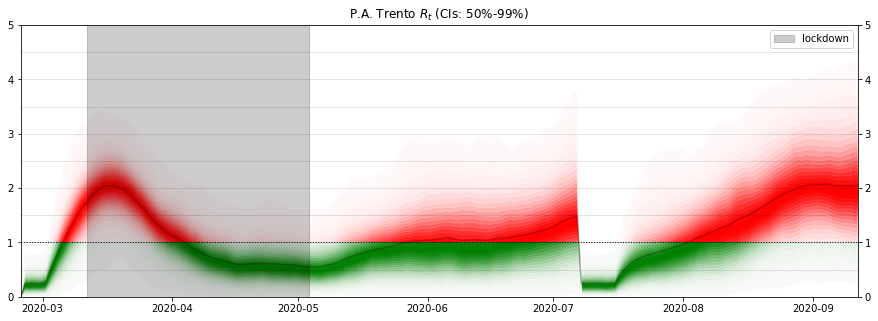

## Piemonte

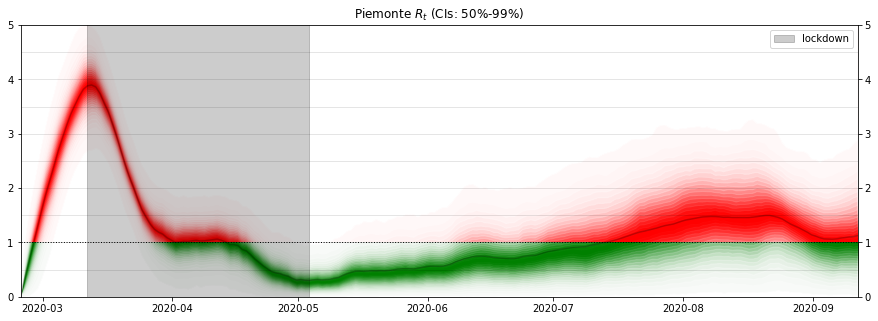

## Puglia

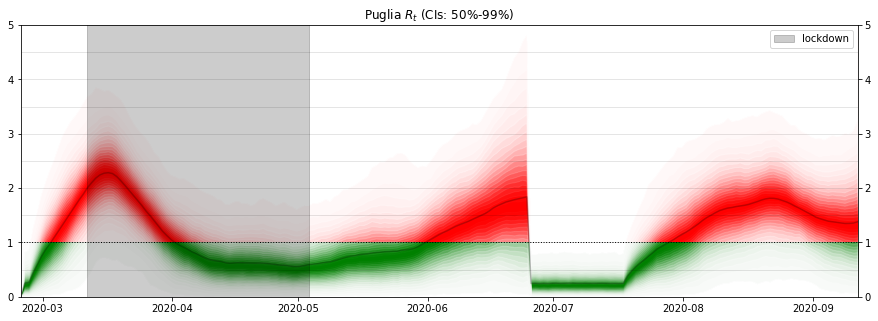

## Sardegna

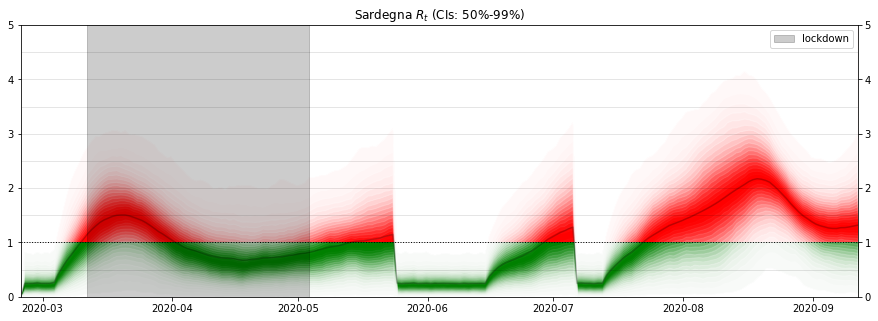

## Sicilia

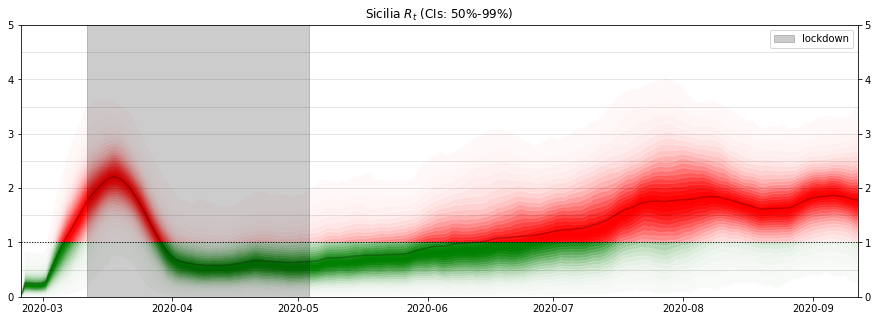

## Toscana

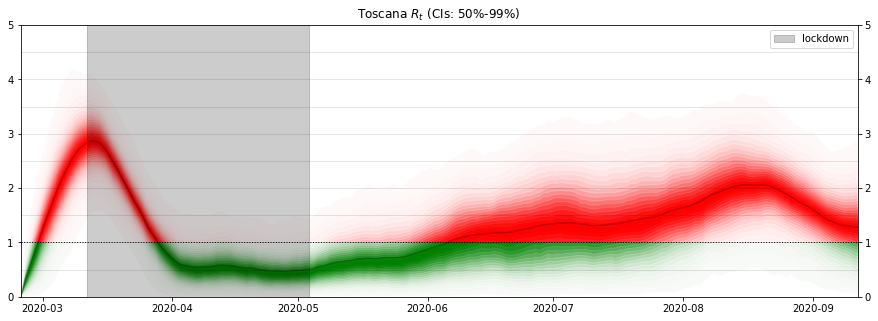

## Umbria

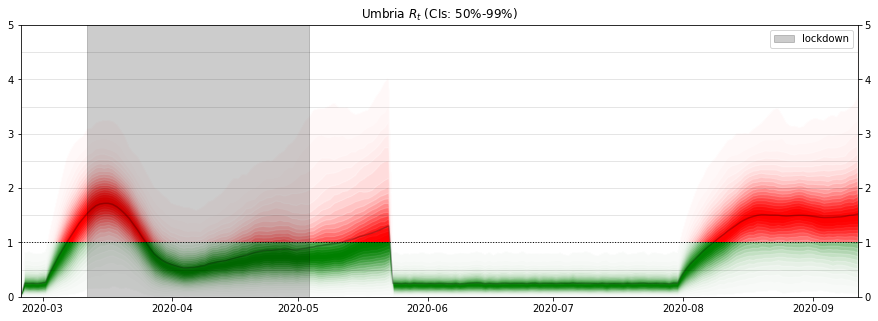

## Valle d'Aosta

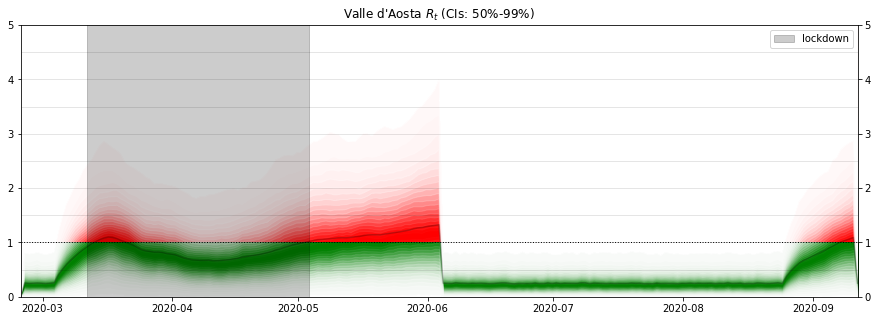

## Veneto

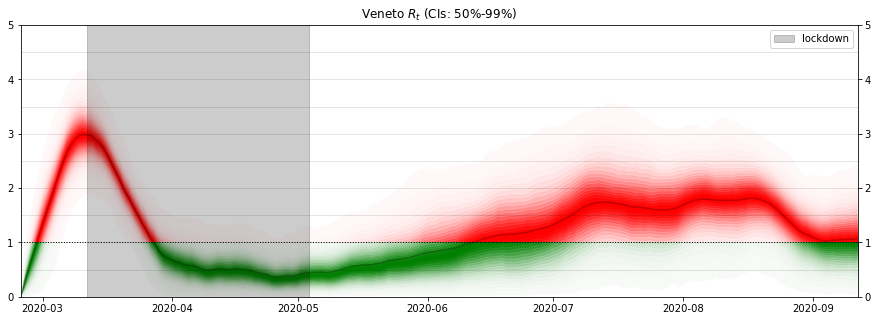

In [10]:
Rt_regioni_json = {}

percs = np.linspace(50, 99, 20)

uppers = np.ndarray(shape=(regions.size, len(percs), daysR.size))
lowers = np.ndarray(shape=(regions.size, len(percs), daysR.size))
means = np.ndarray(shape=(regions.size, daysR.size))

for r, region in enumerate(regions):
    display(Markdown(f"## {region}"))
    
    daysR = days[:jags_posteriors_regions[r].shape[0]]

    ymax = np.array([])

    pyjags_data_regions = az.from_pyjags(
        {"R": jags_posteriors_regions[r]}, 
        warmup_iterations=2000, save_warmup=False)
    summary = az.summary(pyjags_data_regions, var_names="R", kind="stats")
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(pyjags_data_regions.posterior.R, p, axis=1)
        upper = np.mean(upper, axis=0)
        lower = np.percentile(pyjags_data_regions.posterior.R, 100-p, axis=1)
        lower = np.mean(lower, axis=0)
        ymax = np.append(ymax, upper.max())
        uppers[r,i] = upper
        lowers[r,i] = lower
    means[r] = summary["mean"]

    Rt_regioni_json.update({region: summary['mean'][-1]})

    fig, ax = plt.subplots(figsize=(15, 5))

    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r], lowers[r])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax.fill_between(daysR, np.zeros(lower.size), lower, color="w", alpha=alpha)
        ax.fill_between(daysR, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

    ax.fill_betweenx(
        [0,100],
        daysR[daysR>=pd.to_datetime("2020-03-11")][0],
        daysR[daysR<=pd.to_datetime("2020-05-04")][-1],
        color="k", alpha=.2, label="lockdown"
    )

    ax.plot(daysR, summary["mean"], c="k", alpha=.25)

    ax.hlines(np.arange(0, 12, .5), daysR[0], daysR[-1], color="k", lw=1, alpha=.1)
    ax.axhline(1, c="k", ls=":", lw=1)

    ax.fill_between(daysR, 1, 12, color="red", zorder=0) #, alpha=.2)
    ax.fill_between(daysR, 0, 1, color="green", zorder=0) #, alpha=.2)

    ax.set_xlim(daysR[0], daysR[-1])

    ax.set_title(fr"{region} $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

    ax.set_ylim(0, 5)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelright=True)
    ax.legend()

    fig.set_facecolor('w'); plt.show();
    plt.close(fig="all")
    
with open('Rt_regioni.json', 'w') as f:
    json.dump(Rt_regioni_json, f)

## SOMMARIO

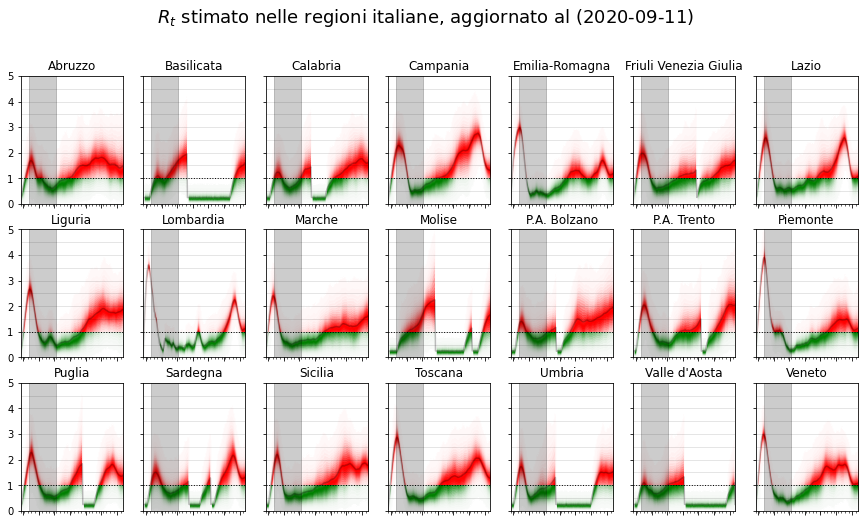

In [11]:
fig, ax = plt.subplots(3, 7, figsize=(15, 8), sharey=True, sharex=True)

for r, region in enumerate(regions):
    
    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r], lowers[r])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax.flat[r].fill_between(daysR, np.zeros(lower.size), lower, color="w", alpha=alpha)
        ax.flat[r].fill_between(daysR, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

    ax.flat[r].fill_betweenx(
        [0,100],
        daysR[daysR>=pd.to_datetime("2020-03-11")][0],
        daysR[daysR<=pd.to_datetime("2020-05-04")][-1],
        color="k", alpha=.2, label="lockdown"
    )

    ax.flat[r].plot(daysR, means[r], c="k", alpha=.25)

    ax.flat[r].hlines(np.arange(0, 12, .5), daysR[0], daysR[-1], color="k", lw=1, alpha=.1)
    ax.flat[r].axhline(1, c="k", ls=":", lw=1)

    ax.flat[r].fill_between(daysR, 1, 12, color="red", zorder=0) #, alpha=.2)
    ax.flat[r].fill_between(daysR, 0, 1, color="green", zorder=0) #, alpha=.2)

    ax.flat[r].set_xlim(daysR[0], daysR[-1])

    ax.flat[r].set_title(fr"{region}")

    ax.flat[r].set_ylim(0, 5)
    
    ax.flat[r].xaxis.set_major_locator(mdates.MonthLocator())
    #ax.flat[r].xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    ax.flat[r].set_xticklabels([])
    ax.flat[r].xaxis.set_minor_locator(mdates.WeekdayLocator())
    
    #ax.flat[r].yaxis.set_ticks_position('both')
    #ax.flat[r].tick_params(labelright=True)

fig.suptitle(f'$R_t$ stimato nelle regioni italiane, aggiornato al ({daysR[-1].date()})', y=1, fontsize=18)
fig.set_facecolor('w'); plt.show();
plt.close(fig="all")

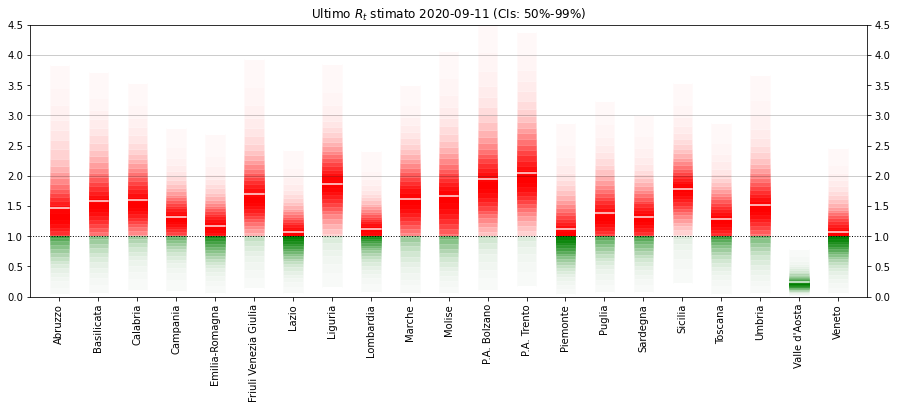

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))

for r, region in enumerate(regions):
    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r,:,-1], lowers[r,:,-1])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax.fill_between([r*2,r*2+1], 1, 12, color="red", zorder=0)
        ax.fill_between([r*2,r*2+1], 0, 1, color="green", zorder=0)
        ax.fill_between(np.linspace(r*2,r*2+1,10), np.zeros(10), lower, color="w", alpha=alpha)
        ax.fill_between(np.linspace(r*2,r*2+1,10), upper, np.ones(10)*12, color="w", alpha=alpha)
    ax.plot(np.linspace(r*2,r*2+1,10), np.ones(10)*means[r][-1], color="w", alpha=.9, zorder=100)

ax.axhline(1, c="k", ls=":", lw=1)
ax.hlines(np.arange(2, 12, 1), -1, regions.size*2+1, lw=1, alpha=.2)
ax.set_ylim(0, 4.5)
ax.set_xlim(-1, regions.size*2)
ax.set_xticks(np.arange(.5, regions.size*2+.5, 2))
ax.set_xticklabels(regions.values, rotation=90)
ax.yaxis.set_ticks_position('both')
ax.tick_params(labelright=True)
ax.set_title(f"Ultimo $R_t$ stimato {days[-1].date()} (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")
fig.set_facecolor('w'); plt.show();

# Rt bayesiano

Italia: $R_t$ (numero di riproduzione effettivo nel tempo $t$) stimato con metodo bayesiano ([Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) e [Kevin Systrom 2020](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb)).

Dettagli metodo: [italian (PDF)](calcolo-Rt.pdf)

In [13]:
def plot_rt(result, ax, state_name, P=[.95, .5]):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,.75,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    update = results.index.get_level_values('data')[-1].date()
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=20,
               lw=.25,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-24'),
                         end=index[-1]+pd.Timedelta(days=1))
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    for j, p in enumerate(P):
        lowfn = interp1d(date2num(index),
                         result[f'Low_{p*100:.0f}'].values,
                         bounds_error=False,
                         fill_value='extrapolate')

        highfn = interp1d(date2num(index),
                          result[f'High_{p*100:.0f}'].values,
                          bounds_error=False,
                          fill_value='extrapolate')



        ax.fill_between(extended,
                        lowfn(date2num(extended)),
                        highfn(date2num(extended)),
                        color='k',
                        alpha=.1*(j+1),
                        lw=0,
                        zorder=3+j)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(mtick.MultipleLocator(1))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-02-24'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    plt.suptitle(
        f"Regioni $R_t$ bayesiano, aggiornato al {update} (HDI {','.join([f'{p:.0%}' for p in sorted(P)])})", 
        fontsize=30, y=1.02)
    fig.set_facecolor('w')
    return values[-1]

In [14]:
defined_p = [.95, .5]

np.seterr(all='ignore')

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7.5

def prepare_cases(cases, cutoff=1, filter_win=7, filter_std=2, smooth_win=14, smooth_std=5):

    cases[cases < 0] = 0

    filtered_states, states_outliers = hampel_filter_pandas(cases, filter_win, filter_std)

    smoothed_states = filtered_states.rolling(smooth_win,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=smooth_std).round()
    smoothed_states[smoothed_states < 0] = 0
    
    #idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed_states = smoothed_states.iloc[cutoff:]
    original = cases.loc[smoothed_states.index]
    
    return original, smoothed_states

def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = np.array([]), np.array([])
    j = 0
    while not lows.size or not highs.size:
        lows, highs = (total_p > (p-j)).nonzero()
        j += .05
        if j > 1:
            break
    
    if not len(lows):
        print("no lo")
        print(pmf)
        print(total_p)
        lows = np.array([0])
    if not len(highs):
        print("no hi")
        highs = np.array([1])
    
    try:
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()
    except Exception as e:
        print("ERR {}".format(e))
        best = 0
    
    try:
        low = pmf.index[lows[best]]
    except Exception as err:
        print(f"lo{p} ERROR: {err}")
        low = 0
    try:
        high = pmf.index[highs[best]]
    except Exception as err:
        print(f"hi{p} ERROR: {err}")
        high = 1
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

def HDI_of_grid(probMassVec, credMass=0.95):
    sortedProbMass = np.sort(probMassVec, axis=None)[::-1]
    HDIheightIdx = np.min(np.where(np.cumsum(sortedProbMass) >= credMass))
    HDIheight = sortedProbMass[HDIheightIdx]
    HDImass = np.sum(probMassVec[probMassVec >= HDIheight])
    idx = np.where(probMassVec >= HDIheight)[0]
    return {'indexes':idx, 'mass':HDImass, 'height':HDIheight}


def HDI_of_grid_from_df(pmf, p):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([HDI_of_grid_from_df(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    res = HDI_of_grid(pmf, p)
    #print(res["indexes"])
    lo_idx = res["indexes"][0]
    hi_idx = res["indexes"][-1]
    
    lo = pmf.index[lo_idx]
    hi = pmf.index[hi_idx]
    
    return pd.Series([lo, hi],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


def HDIs(pmf, P=[.95, .5]):
    RES = []
    for p in P:
        res = HDI_of_grid_from_df(pmf, p=p)
        RES.append(res)
    return RES

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    likelihoods[likelihoods==0] = 1e-15
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        #p_err = np.seterr(all='raise')
        #try:
        #    log_likelihood += np.log(denominator)
        #except Exception as err:
        #    print(f"log err {err} (d={denominator})")
        #    log_likelihood += np.log(1+1e-10)
        #np.seterr(**p_err)
    
    return posteriors, log_likelihood

# targets = ~states.index.get_level_values('denominazione_regione')
# states_to_process = states.loc[states]

#_results = {}

########################### SIGMAS ###########################
sigmas = np.linspace(1/20, 1, 20)

#for state_name, cases in states.groupby(level='denominazione_regione'):
#    print(f"log likelihoods for {state_name}...")
#    smoothed = []
#    cutoff = 20
#    while not len(smoothed):
#        new, smoothed = prepare_cases(cases, cutoff=cutoff)
#        cutoff -= 1
#    
#    result = {}
#    
#    # Holds all posteriors with every given value of sigma
#    result['posteriors'] = []
#    
#    # Holds the log likelihood across all k for each value of sigma
#    result['log_likelihoods'] = []
#    
#    for sigma in sigmas:
#        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
#        result['posteriors'].append(posteriors)
#        result['log_likelihoods'].append(log_likelihood)
#    
#    # Store all results keyed off of state name
#    _results[state_name] = result
#    #clear_output(wait=True)

########################### SIGMAS ###########################

sigma = .25

results = None

for name, cases in states.groupby(level='denominazione_regione'):
    #print(f"Rt {name}...")
    original, smoothed = prepare_cases(cases)
    #if name == "Sardegna":
    #    print(original)
    #    print(smoothed)
    #    plt.plot(original.values, ls=":", c="k")
    #    plt.plot(smoothed.values, ls="-", c="r")

    #sigmas = np.linspace(1/20, 1, 20)
    
    ## Each index of this array holds the total of the log likelihoods for
    ## the corresponding index of the sigmas array.
    #total_log_likelihoods = np.zeros_like(sigmas)
    #
    ## Loop through each state's results and add the log likelihoods to the running total.
    #for state_name, result in results.items():
    #total_log_likelihoods += _results[name]['log_likelihoods']
    #
    ## Select the index with the largest log likelihood total
    #max_likelihood_index = total_log_likelihoods.argmax()
    #
    ## Select the value that has the highest log likelihood
    #sigma = sigmas[max_likelihood_index]
    #print(f"sigma = {sigma}")
    
    # Note that we're fixing sigma to a value just for the example
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)

    # Note that this takes a while to execute - it's not the most efficient algorithm
    #hdis = highest_density_interval(posteriors, p=defined_p)
    HDIS = HDIs(posteriors, P=defined_p)

    most_likely = posteriors.idxmax().rename('ML')

    # Look into why you shift -1
    result = most_likely
    for hdis in HDIS:
        result = pd.concat([result, hdis], axis=1)

    results = pd.concat([results, result])

#clear_output()

In [15]:
def plot_rt_italy(result, name):
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    update = result.index.get_level_values('data')[-1].date()
    
    ax.set_title(f"Italia $R_t$ bayesiano, aggiornato al {update} (CIs 50%-95%)", fontsize=20)
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,.75,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=20,
               lw=.25,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    extended = pd.date_range(start=pd.Timestamp('2020-02-24'),
                         end=index[-1]+pd.Timedelta(days=1))
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lofn = interp1d(date2num(index),
                     result['Low_95'].values,
                     bounds_error=False,
                     fill_value='extrapolate')

    hifn = interp1d(date2num(index),
                      result['High_95'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lofn50 = interp1d(date2num(index),
                     result['Low_50'].values,
                     bounds_error=False,
                     fill_value='extrapolate')

    hifn50 = interp1d(date2num(index),
                      result['High_50'].values,
                      bounds_error=False,
                      fill_value='extrapolate')

    ax.fill_between(extended,
                    lofn(date2num(extended)),
                    hifn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)
    
    ax.fill_between(extended,
                    lofn50(date2num(extended)),
                    hifn50(date2num(extended)),
                    color='k',
                    alpha=.2,
                    lw=0,
                    zorder=4)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(mtick.MultipleLocator(1))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='both', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 4.0)
    ax.set_xlim(pd.Timestamp('2020-02-24'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))

    fig.set_facecolor('w')
    fig.set_facecolor('w'); plt.show();
    plt.close(fig='all')
    
    return values[-1], result['High_95'].values[-1], result['Low_95'].values[-1], result

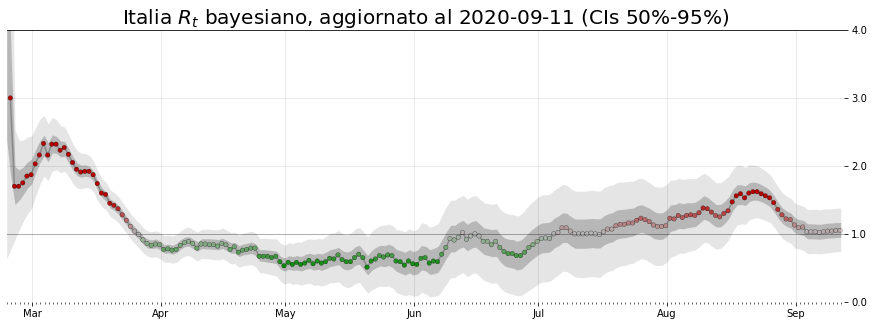

In [16]:
# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed_italy, sigma=.25)

# Note that this takes a while to execute - it's not the most efficient algorithm
#hdis = highest_density_interval(posteriors)
HDIS = HDIs(posteriors)

most_likely = posteriors.idxmax().rename('ML')

result = most_likely
for hdis in HDIS:
    result = pd.concat([result, hdis], axis=1)

R_mean, R_max, R_min, RT = plot_rt_italy(result, "ITALY")

__R0 = {"mean": R_mean, "max": R_max, "min": R_min}
with open("R0_italy.json", "w") as f:
    json.dump(__R0, f)

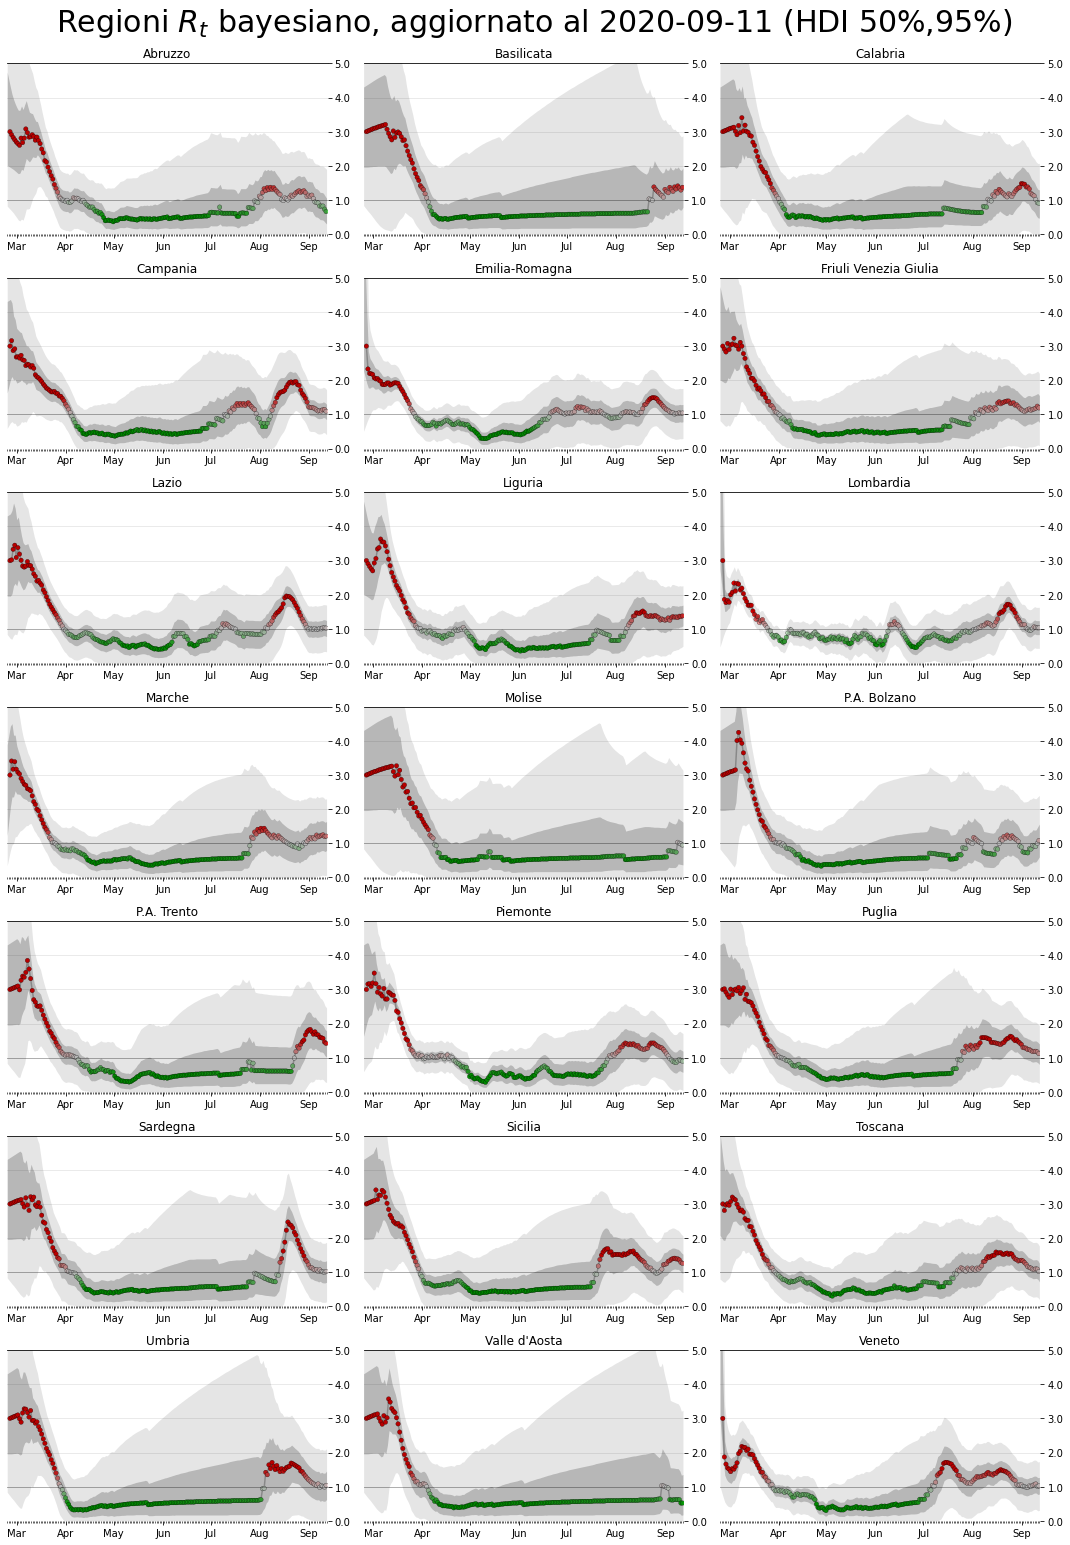

In [17]:
_R0 = {}
ncols = 3
nrows = 7

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.groupby('denominazione_regione')):
    last_Rt = plot_rt(result, axes.flat[i], state_name, P=defined_p)
    _R0.update({state_name: last_Rt})

fig.tight_layout()
fig.set_facecolor('w')

with open("R0_regioni.json", "w") as f:
    json.dump(_R0, f)

***

,ML,High_50,Low_50
denominazione_regione,,,
Abruzzo,0.66,1.07,0.31
Basilicata,1.37,1.92,0.76
Calabria,0.90,1.30,0.47
Campania,1.09,1.31,0.86
Emilia-Romagna,1.04,1.29,0.78
Friuli Venezia Giulia,1.19,1.57,0.78
Lazio,1.02,1.25,0.78
Liguria,1.38,1.69,1.08
Lombardia,1.03,1.24,0.83


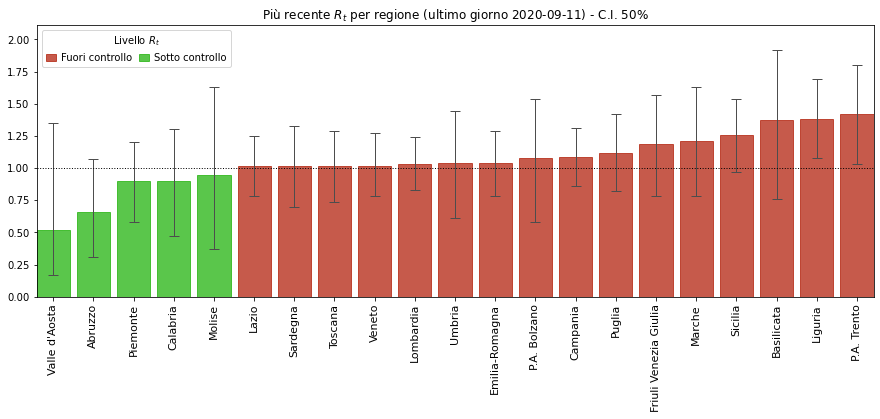

***

,ML,High_50,Low_50
denominazione_regione,,,
Abruzzo,0.812857,1.215714,0.417143
Basilicata,1.338571,1.908571,0.700000
Calabria,1.087143,1.507143,0.640000
Campania,1.115714,1.342857,0.885714
Emilia-Romagna,1.032857,1.285714,0.775714
Friuli Venezia Giulia,1.171429,1.564286,0.752857
Lazio,1.008571,1.242857,0.772857
Liguria,1.355714,1.675714,1.035714
Lombardia,1.011429,1.220000,0.810000


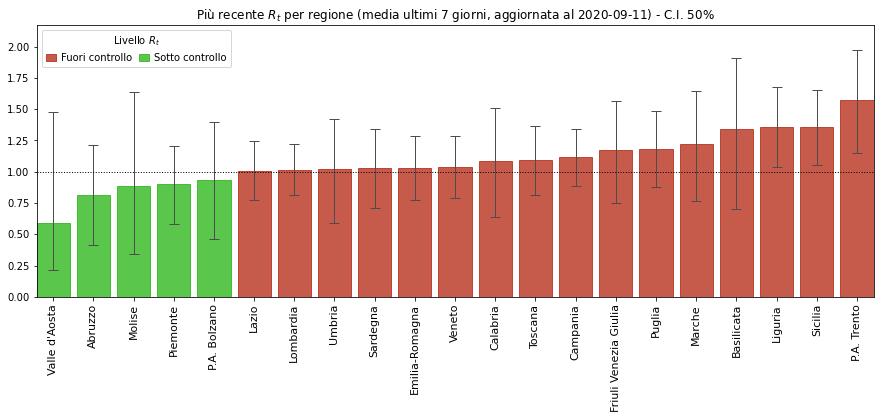

In [18]:
BO_COLOR = [.7,.7,.7]
NO_COLOR = [179/255,35/255,14/255,.75]
OK_COLOR = [.5,.5,.5]
KO_COLOR = [35/255,179/255,14/255,.75]
ERROR_BAR_COLOR = [.3,.3,.3]

def plot_standings(msr, figsize=None, p=.9, days=2):
    display(Markdown("***"))
    mr = msr.groupby(level=0)[['ML', f'High_{p*100:.0f}', f'Low_{p*100:.0f}']].tail(days)
    mr = mr.groupby("denominazione_regione")[['ML', f'High_{p*100:.0f}', f'Low_{p*100:.0f}']].mean()
    display(HTML(mr.to_html()))
    mr.sort_values('ML', inplace=True)
    update = results.index.get_level_values('data')[-1].date()
    
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    if days == 1:
        txt = f"ultimo giorno {update}"
    else:
        txt = f"media ultimi {days} giorni, aggiornata al {update}"
    ax.set_title(f'Più recente $R_t$ per regione ({txt}) - C.I. {p:.0%}')
    
    err = mr[[f'Low_{p*100:.0f}', f'High_{p*100:.0f}']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(np.arange(mr.index.size),
                  mr['ML'],
                  width=.825,
                  color=BO_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=5,
                  error_kw={'alpha':1, 'lw':1},
                  yerr=err.values.T)

    for bar, ml, h90 in zip(bars, mr["ML"], mr[f"High_{p*100:.0f}"]):
        if ml > 1:
            bar.set_color(NO_COLOR)
        #if ml < .75:
        #    bar.set_color(OK_COLOR)
        if ml == 1:
            bar.set_color(BO_COLOR)
        if ml < 1:
            bar.set_color(KO_COLOR)

    labels = mr.index.unique().values  #.replace({'District of Columbia':'DC'})
    ax.set_xticks(np.arange(mr.index.size))
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,max(mr[f"High_{p*100:.0f}"])*1.1)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    ax.legend(handles=[
                        Patch(label='Fuori controllo', color=NO_COLOR),
                        #Patch(label='Unsure', color=BO_COLOR),
                        #Patch(label='Near 0', color=OK_COLOR),
                        Patch(label='Sotto controllo', color=KO_COLOR)
                    ],
                    title='Livello $R_t$',
                    ncol=2,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    #leg._legend_box.align = "left"
    fig.set_facecolor('w')
    fig.set_facecolor('w'); plt.show();
    plt.close(fig="all")
    return fig, ax

plot_standings(results, figsize=(15,5), p=min(defined_p), days=1);
plot_standings(results, figsize=(15,5), p=min(defined_p), days=7);

# Rt come ODDS

Effective reproduction number $R_t$ can be considered as an ODD: if for example $R_t=2$, means like in gambling that the likelihood of contagion is "given 2 to 1", so an infected will infect 2 susceptible subjects.

For the effect of the serial interval $\tau$ (onset of symptoms, diagnosis, etc), new cases $k_t$ observed in day $t$ have been infected in $t-\tau$ by the current new cases observed in $t-\tau$ (because old cases are supposed to be hospitalized, isolated, recovered or dead) so, with this simple method, in $t$ we can calculate the $R_{t-\tau}$.

$$
R_{t-\tau} = \frac{k_{t}}{k_{t-\tau}}
$$

Work in progress: distribute serial interval $\tau$ as **Gamma** and new cases $k_t$ as **Poisson**.

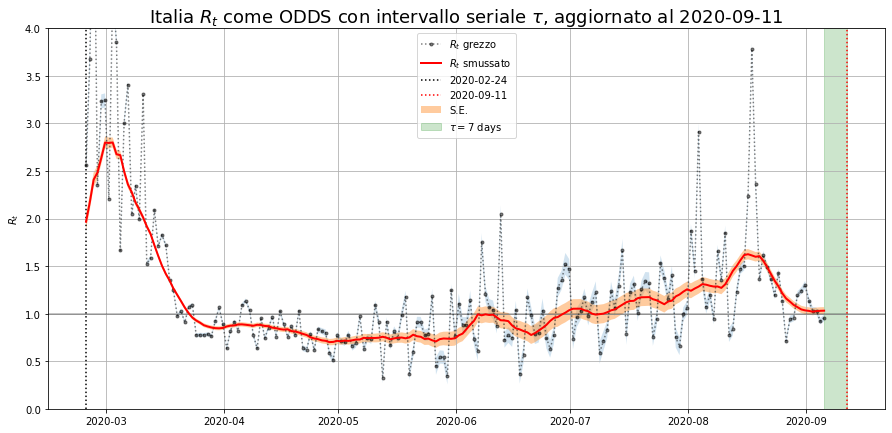

In [19]:
tau = 7

R = italy[tau-1:].values / italy[:-tau+1].values
sR = smoothed_italy[tau-1:].values / smoothed_italy[:-tau+1].values

ES = np.sqrt( 1/italy[tau-1:].values + 1/italy[:-tau+1].values )
sES = np.sqrt( 1/smoothed_italy[tau-1:].values + 1/smoothed_italy[:-tau+1].values )


fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(italy.index[:-tau+1], R, 'ok:', alpha=.5, ms=3, label="$R_t$ grezzo")
ax.fill_between(
    italy.index[:-tau+1],
    R-ES, R+ES, alpha=.2,
)

ax.plot(italy.index[:-tau+1], sR, 'r-', lw=2, zorder=10, label="$R_t$ smussato")
ax.fill_between(
    italy.index[:-tau+1],
    sR-sES, sR+sES, alpha=.4, label="S.E."
)

#ax.axhline(0, c="k", alpha=.7)
ax.axhline(1, c="k", alpha=.3)
ax.axvline(italy.index[0], c="k", ls=":", label=italy.index[0].date())
ax.fill_betweenx(
    [0, max(R)],
    italy.index[-tau], italy.index[-1],
    color="g", alpha=.2,
    label=fr"$\tau = {tau}$ days")

ax.axvline(italy.index[-1], c="r", ls=":", label=italy.index[-1].date())
ax.set_ylabel("$R_t$")
#ax.set_xlabel("Data")
ax.set_ylim(0, 4)
fig.set_facecolor("w")
ax.legend()

update = result.index.get_level_values('data')[-1].date()
ax.set_title(fr"Italia $R_t$ come ODDS con intervallo seriale $\tau$, aggiornato al {update}", fontsize=18)
plt.grid()
plt.plot();